# Notebook 1: Data Exploration

In [ ]:
import os
import json
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from difflib import SequenceMatcher
from tqdm import tqdm
import random

BASE_RAW_PATH = os.path.join('..', '..', 'data', '2_2', 'processed', 'parsed')
MANUAL_DATA_PATH = os.path.join(BASE_RAW_PATH, 'manual')
AUTO_DATA_PATH = os.path.join(BASE_RAW_PATH, 'auto')

SAMPLE_SIZE = 100

STOP_WORDS = {
    'a', 'an', 'the', 'and', 'or', 'of', 'to', 'in', 'on', 'at', 'by', 'for', 
    'with', 'from', 'as', 'is', 'are', 'was', 'were', 'be', 'been', 'this', 'that'
}

## 1. Helper Functions

In [2]:
def clean_latex_string(text):
    if not text:
        return ""
    
    # remove \bibinfo{type}{content} -> content
    text = re.sub(r'\\bibinfo\{.*?\}\{(.*?)\}', r'\1', text)

    # remove latex commands
    text = re.sub(r'\\[a-zA-Z]+\{(.*?)\}', r'\1', text)

    # remove newlines
    text = text.replace('\n', ' ').strip()
    text = re.sub(r'\s+', ' ', text)

    return text

def get_field(field_name, entry):
    field_pattern = re.compile(fr'\b{field_name}\s*=\s*\{{((?:[^{{}}]|\{{[^{{}}]*\}})*)\}}', re.IGNORECASE | re.DOTALL)
    match = field_pattern.search(entry)
    
    if match:
        return match.group(1)
    
    pat_quotes = re.compile(fr'\b{field_name}\s*=\s*\"(.*?)\"', re.IGNORECASE | re.DOTALL)
    match = pat_quotes.search(entry)
    
    if match:
        return match.group(1)  
    else: 
        return None

ADDITIONAL_FIELDS = [
    'journal', 'booktitle', 'volume', 'number', 'pages', 
    'publisher', 'doi', 'url', 'issn', 'isbn', 'month', 'organization'
]

def extract_from_bib(file_content):
    references = []
    raw_entries = re.split(r'^@', file_content, flags=re.MULTILINE)
    
    for entry in raw_entries:
        entry = entry.strip()
        if not entry or entry.startswith('%'): 
            continue
            
        key_match = re.search(r'^(\w+)\s*\{\s*([^,]+),', entry)
        if not key_match:
            continue
            
        ref_type = key_match.group(1)
        ref_id = key_match.group(2).strip()

        if ref_type.lower() in ['string', 'comment', 'preamble']:
            continue
        
        title = clean_latex_string(get_field('title', entry))
        year = get_field('year', entry) or ""
        
        raw_authors = get_field('author', entry)
        if raw_authors:
            cleaned_auth = clean_latex_string(raw_authors)
            authors = [a.strip() for a in cleaned_auth.split(' and ')]
        else:
            authors = []

        ref_data = {
            "id": ref_id,
            "title": title,
            "authors": authors,
            "year": year,
            "source_type": "bib"
        }
        
        for field in ADDITIONAL_FIELDS:
            val = get_field(field, entry)
            if val:
                ref_data[field] = clean_latex_string(val)

        references.append(ref_data)
        
    return references

In [3]:
def get_paper_references(paper_id, data_path):
    if not data_path:
        paper_path = os.path.join(AUTO_DATA_PATH, paper_id)
    else:
        paper_path = os.path.join(data_path, paper_id)

    unique_references = {} 
    
    # search for all .bib files
    for root, dirs, files in os.walk(paper_path):
        for file in files:
            if file.endswith(".bib"):
                try:
                    with open(os.path.join(root, file), 'r', encoding='utf-8', errors='ignore') as f:
                        content = f.read()
                        extracted_references = extract_from_bib(content)
                        
                        for reference in extracted_references:
                            if reference['id'] not in unique_references:
                                unique_references[reference['id']] = reference
                except Exception as e:
                    print(f"Error parsing {file}: {e}")

    return list(unique_references.values())

In [4]:
def clean_text(text):
    if not text: 
        return ""
    
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    tokens = [t for t in text.split() if t not in STOP_WORDS]

    return " ".join(tokens)

def calc_similarity(s1, s2):
    if not s1 or not s2: 
        return 0.0

    return SequenceMatcher(None, s1, s2).ratio()

def tokenize_authors(author_list):
    if not author_list: return set()
    
    text = " ".join(author_list).lower()
    text = re.sub(r'[^a-z\s]', ' ', text)

    return set(text.split())

def calc_jaccard(s1, s2):
    if not s1 or not s2: 
        return 0.0

    return len(s1 & s2) / len(s1 | s2)

def calc_year_diff(year1, year2):
    try:
        if not year1 or not year2: 
            return None
        
        difference = abs(int(str(year1)[:4]) - int(str(year2)[:4]))
        return min(difference, 50)
    except:
        return None

def load_references_full(paper_id, folder_path):
    json_path = os.path.join(folder_path, paper_id, 'references.json')
    
    if not os.path.exists(json_path): 
        return []
        
    try:
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
            
        if data is None or not isinstance(data, dict):
            return []
            
    except: 
        return []
    
    targets = []
    for aid, meta in data.items():
        if not meta: continue
        
        date_str = meta.get('submission_date', "")
        year = date_str.split('-')[0] if date_str else ""
        
        targets.append({
            "clean_title": clean_text(meta.get('title', "")),
            "author_tokens": tokenize_authors(meta.get('authors', [])),
            "year": year
        })
    return targets

## 2. Data Quality Check

### 2.1 From .bib and .tex files

In [5]:
def run_source_data_quality_check(folder_path, sample_size=SAMPLE_SIZE):
    paper_ids = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    
    if sample_size and len(paper_ids) > sample_size:
        import random
        random.seed(42)
        paper_ids = random.sample(paper_ids, sample_size)
        
    print(f"Checking SOURCE quality for {len(paper_ids)} papers...")
    
    basic_fields = ['title', 'authors', 'year']
    extra_fields = ['journal', 'volume', 'publisher', 'doi', 'url']
    
    stats = {
        'total_refs': 0,
        'bib_source': 0,     
        'bibitem_source': 0
    }
    
    for f in basic_fields + extra_fields:
        stats[f'missing_{f}'] = 0
    
    for pid in tqdm(paper_ids):
        refs = get_paper_references(pid, folder_path)
        
        for r in refs:
            stats['total_refs'] += 1
            
            if r.get('source_type') == 'bib':
                stats['bib_source'] += 1
            else:
                stats['bibitem_source'] += 1
                
            if not r.get('title') or len(r.get('title')) < 5:
                stats['missing_title'] += 1
            
            if not r.get('authors') or (len(r.get('authors')) == 1 and r.get('authors')[0] == ''):
                stats['missing_authors'] += 1
                
            if not r.get('year') or str(r.get('year')).strip() == "":
                stats['missing_year'] += 1
                
            # check Additional Fields
            for field in extra_fields:
                val = r.get(field)
                if not val or str(val).strip() == "":
                    stats[f'missing_{field}'] += 1

    total = stats['total_refs']
    if total == 0:
        print("No references extracted. Check your paths/parsers.")
        return

    print("\n" + "="*40)
    print("SOURCE DATA QUALITY REPORT")
    print("="*40)
    print(f"Total References Extracted: {total}")
    print(f"Source Breakdown: .bib={stats['bib_source'] / total:.1%} | .tex={stats['bibitem_source'] / total:.1%}")
    print("-" * 40)
    
    print("--- Core Metadata ---")
    print(f"Missing Titles:  {stats['missing_title']} ({stats['missing_title']/total:.2%})")
    print(f"Missing Authors: {stats['missing_authors']} ({stats['missing_authors']/total:.2%})")
    print(f"Missing Years:   {stats['missing_year']} ({stats['missing_year']/total:.2%})")
    
    print("\n--- Additional Metadata ---")
    for field in extra_fields:
        count = stats[f'missing_{field}']
        present = total - count
        print(f"Has {field.capitalize()}: {present} ({present/total:.2%})")

In [6]:
run_source_data_quality_check(AUTO_DATA_PATH)

Checking SOURCE quality for 2000 papers...


100%|██████████| 2000/2000 [00:13<00:00, 149.90it/s]


SOURCE DATA QUALITY REPORT
Total References Extracted: 75159
Source Breakdown: .bib=100.0% | .tex=0.0%
----------------------------------------
--- Core Metadata ---
Missing Titles:  5432 (7.23%)
Missing Authors: 8996 (11.97%)
Missing Years:   14437 (19.21%)

--- Additional Metadata ---
Has Journal: 43902 (58.41%)
Has Volume: 35156 (46.78%)
Has Publisher: 17913 (23.83%)
Has Doi: 25476 (33.90%)
Has Url: 10350 (13.77%)


### 2.2 From References.json

In [7]:
def run_target_data_quality_check(folder_path, sample_size=SAMPLE_SIZE):
    paper_ids = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    
    if sample_size and len(paper_ids) > sample_size:
        random.seed(42)
        paper_ids = random.sample(paper_ids, sample_size)
        
    print(f"Checking data quality for {len(paper_ids)} papers...")
    
    all_years = []
    title_lengths = []
    short_titles = []
    
    missing_stats = {'title': 0, 'authors': 0, 'year': 0, 'total': 0}
    
    extra_fields = ['journal', 'venue', 'publication_venue', 'doi', 'url', 'SemanticScholarId']
    extra_stats = {f: 0 for f in extra_fields}
    
    for pid in tqdm(paper_ids):
        json_path = os.path.join(folder_path, pid, 'references.json')
        if not os.path.exists(json_path): continue
        
        try:
            with open(json_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            if not isinstance(data, dict): continue
        except: continue
            
        for aid, meta in data.items():
            if not meta: continue
            
            missing_stats['total'] += 1
            
            if not meta.get('title') or str(meta.get('title')).strip() == "":
                missing_stats['title'] += 1
            
            if not meta.get('authors') or len(meta.get('authors')) == 0:
                missing_stats['authors'] += 1
            
            if not meta.get('submission_date') or str(meta.get('submission_date')).strip() == "":
                missing_stats['year'] += 1

            date_str = meta.get('submission_date', "")
            if date_str:
                y_str = str(date_str).split('-')[0]
                if y_str.isdigit():
                    all_years.append(int(y_str))
            
            clean_t = clean_text(meta.get('title', ""))
            t_len = len(clean_t)

            if t_len > 0:
                title_lengths.append(t_len)
                if t_len < 10:
                    short_titles.append(clean_t)
            
            for field in extra_fields:
                val = meta.get(field)
                if val:
                    extra_stats[field] += 1

    all_years = np.array(all_years)
    title_lengths = np.array(title_lengths)
    total = missing_stats['total']
    
    print("\n" + "="*40)
    print("TARGET DATA QUALITY REPORT (references.json)")
    print("="*40)
    
    print(f"\n--- 1. Year Validity (N={len(all_years)}) ---")
    if len(all_years) > 0:
        print(f"Min Year: {np.min(all_years)}")
        print(f"Max Year: {np.max(all_years)}")
        suspicious_years = all_years[(all_years < 1950) | (all_years > 2025)]
        print(f"Suspicious Years: {len(suspicious_years)} ({len(suspicious_years)/len(all_years):.2%})")
    
    print(f"\n--- 2. Title Length (N={len(title_lengths)}) ---")
    if len(title_lengths) > 0:
        print(f"Min Length: {np.min(title_lengths)}")
        print(f"Max Length: {np.max(title_lengths)}")
        too_short = len([l for l in title_lengths if l < 10])
        print(f"Titles < 10 chars: {too_short} ({too_short/len(title_lengths):.2%})")
        if short_titles:
            print(f"Examples: {short_titles[:3]}")

    print(f"\n--- 3. Missing Core Values (N={total}) ---")
    if total > 0:
        print(f"Missing Titles:  {missing_stats['title']} ({missing_stats['title']/total:.2%})")
        print(f"Missing Authors: {missing_stats['authors']} ({missing_stats['authors']/total:.2%})")
        print(f"Missing Years:   {missing_stats['year']} ({missing_stats['year']/total:.2%})")
        
    print(f"\n--- 4. Additional Metadata Availability (N={total}) ---")
    if total > 0:
        for field in extra_fields:
            count = extra_stats[field]
            print(f"Has {field}: {count} ({count/total:.2%})")
    else:
        print("No entries found.")

In [8]:
run_target_data_quality_check(AUTO_DATA_PATH)

Checking data quality for 2000 papers...


100%|██████████| 2000/2000 [00:00<00:00, 3149.82it/s]


TARGET DATA QUALITY REPORT (references.json)

--- 1. Year Validity (N=34686) ---
Min Year: 1900
Max Year: 2025
Suspicious Years: 1 (0.00%)

--- 2. Title Length (N=34686) ---
Min Length: 5
Max Length: 269
Titles < 10 chars: 37 (0.11%)
Examples: ['axions', 'deep sets', 'bl rings']

--- 3. Missing Core Values (N=34686) ---
Missing Titles:  0 (0.00%)
Missing Authors: 11 (0.03%)
Missing Years:   0 (0.00%)

--- 4. Additional Metadata Availability (N=34686) ---
Has journal: 0 (0.00%)
Has venue: 0 (0.00%)
Has publication_venue: 0 (0.00%)
Has doi: 0 (0.00%)
Has url: 0 (0.00%)
Has SemanticScholarId: 34686 (100.00%)


## 3. Candidate Distinctness Analysis

In [9]:
def collect_multivariate_stats(folder_path, sample_size = SAMPLE_SIZE):
    paper_ids = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    
    if sample_size and len(paper_ids) > sample_size:
        random.seed(42)
        paper_ids = random.sample(paper_ids, sample_size)
    
    stats = {
        'title_sim': [],
        'author_sim': [],
        'year_diff': []
    }
    
    print(f"Mining pairwise stats from {len(paper_ids)} papers...")
    
    for pid in tqdm(paper_ids):
        candidates = load_references_full(pid, folder_path)
        if len(candidates) < 2: continue
        
        n = len(candidates)
        for i in range(n):
            for j in range(i + 1, n):
                c1, c2 = candidates[i], candidates[j]
                
                stats['title_sim'].append(calc_similarity(c1['clean_title'], c2['clean_title']))
                
                stats['author_sim'].append(calc_jaccard(c1['author_tokens'], c2['author_tokens']))
                
                yd = calc_year_diff(c1['year'], c2['year'])
                if yd is not None:
                    stats['year_diff'].append(yd)
                    
    return stats

In [10]:
multi_stats = collect_multivariate_stats(AUTO_DATA_PATH) 

Mining pairwise stats from 2000 papers...


100%|██████████| 2000/2000 [01:43<00:00, 19.40it/s]


In [11]:
def print_detailed_stats(data, metric_name):
    arr = np.array(data)
    
    p25 = np.percentile(arr, 25)
    p50 = np.percentile(arr, 50)
    p75 = np.percentile(arr, 75)
    p99 = np.percentile(arr, 99)
    max_val = np.max(arr)
    
    print(f"--- Distribution Statistics ({metric_name}) ---")
    print(f"{'25th Percentile:':<18} {p25:.4f}")
    print(f"{'Median (50%):':<18} {p50:.4f}")
    print(f"{'75th Percentile:':<18} {p75:.4f}")
    print(f"{'99th Percentile:':<18} {p99:.4f}")
    print(f"{'Max Score:':<18} {max_val:.4f}")

### 3.1 Title Difference

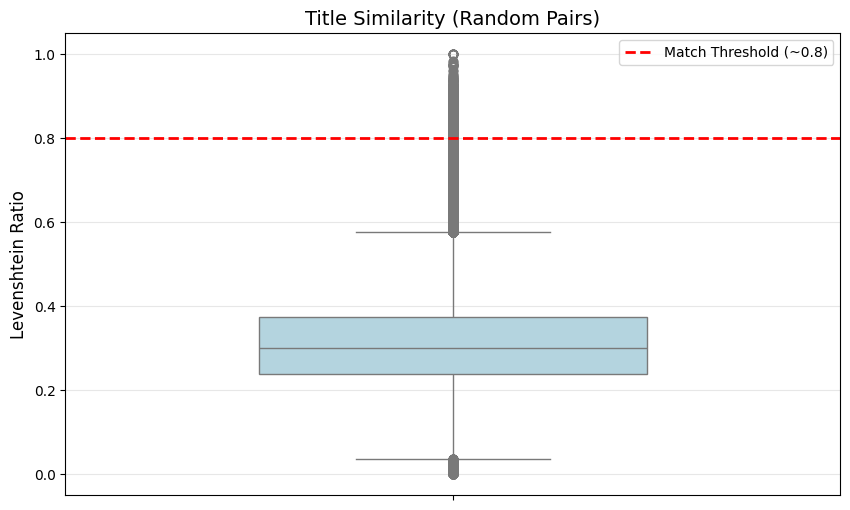

--- Distribution Statistics (Title Similarity) ---
25th Percentile:   0.2385
Median (50%):      0.3014
75th Percentile:   0.3733
99th Percentile:   0.6346
Max Score:         1.0000


In [12]:
plt.figure(figsize=(10, 6))
data = multi_stats['title_sim']

sns.boxplot(
    y=data, 
    color='lightblue', 
    width=0.5
)
plt.axhline(0.8, color='red', linestyle='--', linewidth=2, label='Match Threshold (~0.8)')

plt.title("Title Similarity (Random Pairs)", fontsize=14)
plt.ylabel("Levenshtein Ratio", fontsize=12)
plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.3)
plt.ylim(-0.05, 1.05) 

plt.show()

print_detailed_stats(data, "Title Similarity")

### 3.2 Author Difference

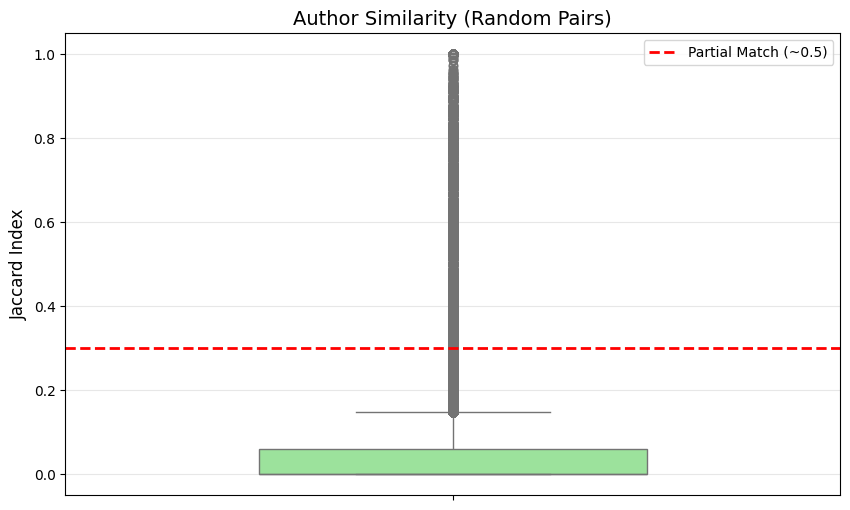

--- Distribution Statistics (Author Similarity) ---
25th Percentile:   0.0000
Median (50%):      0.0000
75th Percentile:   0.0588
99th Percentile:   0.5000
Max Score:         1.0000


In [15]:
plt.figure(figsize=(10, 6))
data = multi_stats['author_sim']

sns.boxplot(
    y=data, 
    color='lightgreen', 
    width=0.5
)
plt.axhline(0.3, color='red', linestyle='--', linewidth=2, label='Partial Match (~0.5)')

plt.title("Author Similarity (Random Pairs)", fontsize=14)
plt.ylabel("Jaccard Index", fontsize=12)
plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.3)
plt.ylim(-0.05, 1.05)

plt.show()

print_detailed_stats(data, "Author Similarity")

### 3.3 Year Difference

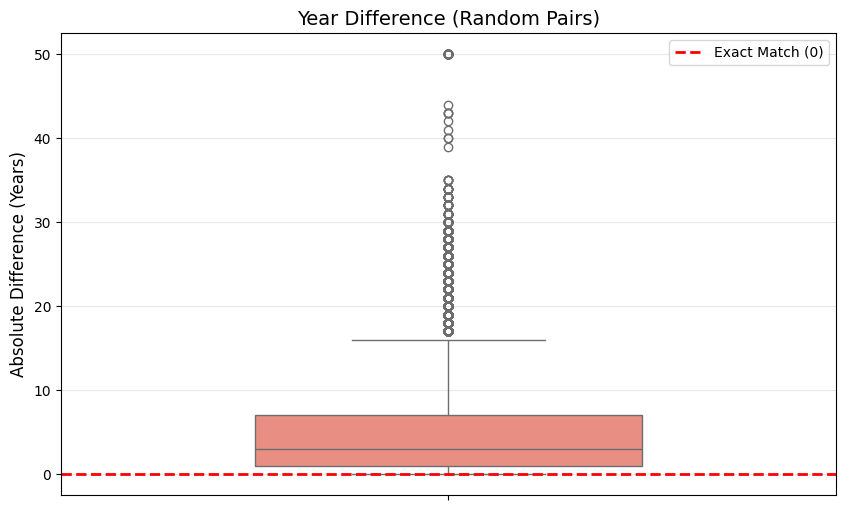

--- Distribution Statistics (Year Difference) ---
25th Percentile:   1.0000
Median (50%):      3.0000
75th Percentile:   7.0000
99th Percentile:   23.0000
Max Score:         50.0000


In [14]:
plt.figure(figsize=(10, 6))
data = multi_stats['year_diff']

sns.boxplot(
    y=data, 
    color='salmon', 
    width=0.5
)
plt.axhline(0, color='red', linestyle='--', linewidth=2, label='Exact Match (0)')

plt.title("Year Difference (Random Pairs)", fontsize=14)
plt.ylabel("Absolute Difference (Years)", fontsize=12)
plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.3)

plt.show()

print_detailed_stats(data, "Year Difference")